In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic_dd
import pandas as pd
from itertools import product
import os
import sys
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
from scipy.stats import spearmanr
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
sys.path.append("../data_extraction/")
from utils import flatten_logic
from functools import reduce

In [2]:
FEATURE_COLUMNS = ['Valence', 'Arousal', 'Dominance', 'Politeness', 'Formality']

In [3]:
def get_bins(data, num_bins):
    """Return the bin index that each data point in data falls into, given the space
    is subdivided to have num_bins equally sized bins.

    A bin number of i means that the corresponding value is between bin_edges[i-1], bin_edges[i]

    Returns both the bin index as a unique integer, as well as in terms of a 5d
    array corresponding to each dimension.
    """
    # Initialize uniformly-sized bins
    bin_edges = []
    for feature in FEATURE_COLUMNS:
        bin_edges.append(np.quantile(data[feature], np.linspace(0, 1, num_bins + 1)))
    bin_edges = np.array(bin_edges)
    bin_edges[:, 0] = 0
    bin_edges[:, -1] = 1

    data = data.to_numpy()
    
    stats, edges, unraveled_binnumber = binned_statistic_dd(data, np.arange(len(data)),
                                                            statistic="mean",
                                                            bins=bin_edges,
                                                            expand_binnumbers=True)

    # Return the bin IDs
    return unraveled_binnumber.transpose()

In [4]:
ROOT_DIR = "/ais/hal9000/datasets/reddit/stance_pipeline/nov_27_test_run/full_features/"
files = sorted(os.listdir(ROOT_DIR))
dfs = []
for file in files:
    df = pd.read_csv(ROOT_DIR + file)
    dfs.append(df)
df = pd.concat(dfs)
del dfs
df = df.set_index("id")
df['rel_marker'] = df['rel_marker'].apply(lambda x: eval(x)[0])
df['Politeness'] = (df["Politeness"] - df['Politeness'].min())/(df['Politeness'].max() - df['Politeness'].min()) 

In [5]:
def get_bin_names(arr):
    features = np.array(list("VADPF"))
    added = np.char.add(features, arr.astype(str))
    names = np.sum(added.astype(object), axis=1)
    return names

ubins = get_bins(df[FEATURE_COLUMNS], 2)  
df['bin'] = get_bin_names(ubins)
df['bin'].describe()

count        7138111
unique            32
top       V2A2D2P2F2
freq          451997
Name: bin, dtype: object

In [6]:
x = df.groupby("bin").mean()[FEATURE_COLUMNS]

In [7]:
# Get all unique markers
all_markers = sorted(df['rel_marker'].unique())
# Combine the subreddit and marker and aggregate
df['sub_marker'] = df["subreddit"] + "_" + df['rel_marker']
agg = df.groupby(["bin", "sub_marker"]).count()

In [15]:
# Get all unique communities and bins
comms = df['subreddit'].unique()
markers = df['rel_marker'].unique()
bins = df['bin'].unique()
com_markers = list(product(comms, markers))
com_markers = ["_".join(pair) for pair in com_markers]
len(com_markers)

4540

In [9]:
# Need probability
sem_sit_counts = df.groupby(["bin"]).count()['body']
sem_sit_counts_per_community = df.groupby(["subreddit", "bin"]).count()[['body', "author"]]
all_sub_counts = pd.DataFrame(0, index=pd.MultiIndex.from_product([bins, comms], names=["bin", "subreddit"]), columns=sem_sit_counts_per_community.columns)
sem_sit_counts_per_community = sem_sit_counts_per_community.add(all_sub_counts, fill_value=0)
sem_sit_counts_per_community['percent'] = sem_sit_counts_per_community.groupby(level=0)['body'].transform(lambda x: (x / x.sum()))
norm_sem_sit_counts = sem_sit_counts/sem_sit_counts.sum()
print(norm_sem_sit_counts.describe())
com_to_need = {}
for sub in comms:
    need_vec = sem_sit_counts_per_community.loc[sub]['percent']
    com_to_need[sub] = need_vec.to_numpy()
need_df = pd.DataFrame(com_to_need).T
need_df.columns = sem_sit_counts_per_community.loc[sub].index
need_df.describe()

count    32.000000
mean      0.031250
std       0.016164
min       0.004895
25%       0.017656
50%       0.031221
75%       0.042236
max       0.063322
Name: body, dtype: float64


bin,V1A1D1P1F1,V1A1D1P1F2,V1A1D1P2F1,V1A1D1P2F2,V1A1D2P1F1,V1A1D2P1F2,V1A1D2P2F1,V1A1D2P2F2,V1A2D1P1F1,V1A2D1P1F2,...,V2A1D2P2F1,V2A1D2P2F2,V2A2D1P1F1,V2A2D1P1F2,V2A2D1P2F1,V2A2D1P2F2,V2A2D2P1F1,V2A2D2P1F2,V2A2D2P2F1,V2A2D2P2F2
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.058017,0.032853,0.037892,0.032792,0.016397,0.013988,0.005451,0.008282,0.048353,0.031420,...,0.041098,0.050466,0.008878,0.004779,0.017596,0.015021,0.024323,0.029599,0.043729,0.067197
std,0.016809,0.011451,0.007965,0.007807,0.005651,0.008367,0.001243,0.003142,0.014170,0.011214,...,0.010876,0.015511,0.003210,0.001609,0.006762,0.006747,0.007916,0.009280,0.018034,0.031271
min,0.029231,0.017209,0.022873,0.022098,0.008605,0.004933,0.003492,0.003824,0.021887,0.011670,...,0.023282,0.033374,0.003088,0.002662,0.006811,0.005884,0.013363,0.015752,0.018137,0.023031
25%,0.046897,0.022509,0.031143,0.027175,0.013358,0.008686,0.004771,0.006409,0.040041,0.024886,...,0.035157,0.039334,0.007182,0.003303,0.011858,0.008819,0.016984,0.023405,0.028402,0.038435
50%,0.054408,0.030201,0.038166,0.031594,0.015502,0.012336,0.005255,0.007442,0.047299,0.028834,...,0.040383,0.046546,0.008989,0.004573,0.018354,0.014710,0.024414,0.029035,0.042908,0.071088
75%,0.070361,0.040618,0.045523,0.038565,0.017842,0.015890,0.005887,0.009197,0.057393,0.036701,...,0.045386,0.052689,0.010066,0.005618,0.020878,0.019879,0.029193,0.034604,0.054433,0.081645
max,0.092990,0.054274,0.050907,0.047835,0.035554,0.043124,0.008092,0.016111,0.079701,0.054301,...,0.076237,0.091390,0.017631,0.008250,0.031700,0.027314,0.038163,0.051424,0.082270,0.139845


In [10]:
def get_nonzero_prop(df):
    print(np.round(np.count_nonzero(df)/df.size, 2))
    
# Create a matrix of all possible semantic situations and community markers with 0 values
full_counts = pd.DataFrame(0, index=pd.MultiIndex.from_product([bins, com_markers], names=["bin", "sub_marker"]), columns=agg.columns)
# Add to our attested matrix to fill in the blanks and get a full matrix
total = agg.add(full_counts, fill_value=0)
total = total.reset_index()
# Create co-occurrence matrices
cooc_matrix = pd.crosstab(total['bin'], total['sub_marker'], total['body'], aggfunc="sum")
pav_matrix = pd.crosstab(df['subreddit'], df['rel_marker'])
print(f"Full Co-occurrence Matrix Size: {cooc_matrix.shape}")
get_nonzero_prop(cooc_matrix)
print(f"Pavalanathan Matrix Size: {pav_matrix.shape}")
get_nonzero_prop(pav_matrix)

Full Co-occurrence Matrix Size: (32, 4540)
0.49
Pavalanathan Matrix Size: (20, 227)
0.9


In [11]:
# Extract co-occurrence matrix per subreddit to get words that are sufficiently infrequent
all_subs = []
for i in range(len(comms)):
    sub = cooc_matrix.iloc[:, i*len(markers):(i+1)*len(markers)]
    sub.columns = [col[col.index("_") + 1:] for col in sub.columns]
    all_subs.append(sub)

whole_counts = reduce(lambda a, b: a.add(b, fill_value=0), all_subs)
whole_agg = whole_counts.sum()
markers_to_keep = whole_agg.index#set(whole_agg[whole_agg <= 100000].index)
cooc_matrix = cooc_matrix[[col for col in cooc_matrix.columns if col[col.find("_") + 1:] in markers_to_keep]]
pav_matrix = pav_matrix[[col for col in pav_matrix.columns if col in markers_to_keep]]

In [12]:
def pmi(df, positive=True):
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    df = df / expected
    # Silence distracting warnings about log(0):
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  # log(0) = 0
    if positive:
        df[df < 0] = 0.0
        df = np.nan_to_num(df)
    return df

In [13]:
def create_derived_representation(matrix):
    matrix_np = matrix.to_numpy()
    print(matrix_np.shape)
    ppmi = pmi(matrix_np)
    get_nonzero_prop(ppmi)
    P, D, Q = np.linalg.svd(ppmi, full_matrices=False)
    return matrix_np, ppmi, P, D, Q

def scree_plot(sing_val_matrix):
    var_explained = np.round(sing_val_matrix**2/np.sum(sing_val_matrix**2), decimals=3)
    print(var_explained[:10])
    print(np.cumsum(var_explained)[:10])
    plt.clf()
    plt.plot(np.arange(len(var_explained[:10])), var_explained[:10])
    plt.xlabel("Component Number")
    plt.ylabel("Eigenvalue")
    plt.title("Scree plot of Co-occurrence Matrix")
    plt.show()


In [14]:
our_cooc, our_ppmi, our_p, our_d, our_q = create_derived_representation(cooc_matrix)
pav_cooc, pav_ppmi, pav_p, pav_d, pav_q = create_derived_representation(pav_matrix)

(32, 4540)
0.27
(20, 227)
0.36


/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


[0.199 0.052 0.045 0.041 0.037 0.036 0.033 0.031 0.03  0.029]
[0.199 0.251 0.296 0.337 0.374 0.41  0.443 0.474 0.504 0.533]


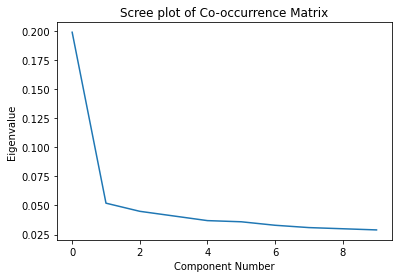

In [17]:
# scree_plot(pav_d)
scree_plot(our_d)
new_P = our_p[:, :6]
# ADd this to the report> Show that the first dimension captures the majority of the variance, but we can take up to the 6 

In [63]:
# ppmi = pmi(cooc_matrix_np)
# cooc_matrix_np = cooc_matrix.to_numpy()
# print(cooc_matrix.shape)
# P, D, Q = np.linalg.svd(ppmi, full_matrices=False)

In [19]:
def mds_visualization(lowdim, labels, feature, delegate, plot_markers, delegate_labels, derived_label, to_annotate):
    # Rewrite into wrapper function that computes mds just once and can be used for an arbitrary number of features
    fig = plt.figure(figsize=(20, 10))
    for i in range(len(delegate_labels)):
        vals = np.array([idx for idx, label in enumerate(labels) if delegate(label, delegate_labels[i], feature)]).astype(int)
        plt.plot(lowdim[vals, 0], lowdim[vals, 1], plot_markers[i], markersize=12, label=f"Low {feature}")
    plt.legend()
    if to_annotate:
        for i in range(len(lowdim)):
            plt.text(lowdim[i,0]*1.05, lowdim[i,1]*1.01, labels[i],fontsize=17)

    plt.xlabel('Dimension 1')    
    plt.ylabel('Dimension 2')
    plt.title(f"MDS Plot of {derived_label} Semantic Situation Space ({feature})")



In [20]:
quantile_to_plot_markers = {
    2: ["ro", "gs"],
    3: ["ro", "bx", "gs"],
    4: ["ro", "bo", "ys", "gs"]
}

def mds_wrapper(data, labels, features, delegate, num_quantiles=2, num_components=2, is_derived=False, to_annotate=False):
    embedding = MDS(n_components=num_components, random_state=42)
    F_lowdim = embedding.fit_transform(data)
    print(F_lowdim.shape)

    plot_markers = quantile_to_plot_markers[num_quantiles]
    derived_label = "Derived" if is_derived else "Original"
    delegate_labels = [str(i+1) for i in range(num_quantiles)]

    for feature in features:
        mds_visualization(F_lowdim, labels, feature, delegate, plot_markers, delegate_labels, derived_label, to_annotate)



In [65]:
def mds_visualization_3(data, labels, feature, delegate):
    plt.rcParams.update({"font.size": 20})
    embedding = MDS(n_components=2, random_state=42)
    F_lowdim = embedding.fit_transform(data)
    print(F_lowdim.shape)
    fig = plt.figure(figsize=(20, 10))
    low_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "1", feature)]).astype(int)
    mid_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "2", feature)]).astype(int)
    high_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "3", feature)]).astype(int)
    plt.plot(F_lowdim[low_val, 0], F_lowdim[low_val, 1], "bo", markersize=12, label=f"Low {feature}")
    plt.plot(F_lowdim[mid_val, 0], F_lowdim[mid_val, 1], "rx", markersize=12, label=f"Mid {feature}")
    plt.plot(F_lowdim[high_val, 0], F_lowdim[high_val, 1], "gs", markersize=12, label=f"High {feature}")
    plt.legend()
    # for i in range(len(F_lowdim)):
    #     plt.text(F_lowdim[i,0]*1.05, F_lowdim[i,1]*1.01, labels[i],fontsize=17)

    plt.xlabel('Dimension 1')    
    plt.ylabel('Dimension 2')
    plt.title(f"MDS Plot of Semantic Situation Space ({feature})")
    plt.show()



In [66]:
def mds_visualization_4(data, labels, feature, delegate):
    plt.rcParams.update({"font.size": 20})
    embedding = MDS(n_components=2, random_state=42)
    F_lowdim = embedding.fit_transform(data)
    print(F_lowdim.shape)
    fig = plt.figure(figsize=(20, 10))
    low_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "1", feature)]).astype(int)
    midlow_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "2", feature)]).astype(int)
    midhigh_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "3", feature)]).astype(int)
    high_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "4", feature)]).astype(int)
    plt.plot(F_lowdim[low_val, 0], F_lowdim[low_val, 1], "bo", markersize=12, label=f"Low {feature}")
    plt.plot(F_lowdim[midlow_val, 0], F_lowdim[midlow_val, 1], "ro", markersize=12, label=f"Mid-low {feature}")
    plt.plot(F_lowdim[midhigh_val, 0], F_lowdim[midhigh_val, 1], "ys", markersize=12, label=f"Mid-high {feature}")
    plt.plot(F_lowdim[high_val, 0], F_lowdim[high_val, 1], "gs", markersize=12, label=f"High {feature}")
    plt.legend()
    # for i in range(len(F_lowdim)):
    #     plt.text(F_lowdim[i,0]*1.05, F_lowdim[i,1]*1.01, labels[i],fontsize=17)

    plt.xlabel('Dimension 1')    
    plt.ylabel('Dimension 2')
    plt.title(f"MDS Plot of Semantic Situation Space ({feature})")
    plt.show()



In [67]:
feature_to_index = {
    "Valence": 1,
    "Arousal": 3,
    "Dominance": 5,
    "Politeness": 7,
    "Formality": 9
}

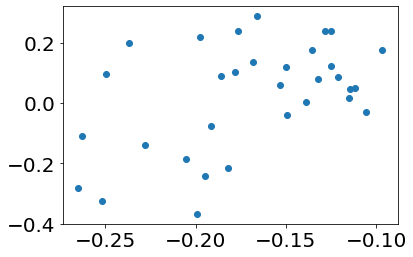

In [74]:
plt.scatter(new_P[:, 0], new_P[:, 1])

In [95]:
original_dist_matrix = cosine_similarity(our_cooc)
derived_dist_matrix = cosine_similarity(new_P)
# original_dist_matrix = cdist(cooc_matrix_np, cooc_matrix_np)
# derived_dist_matrix = cdist(new_P, new_P)

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(32, 2)
(32, 2)


/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(32, 2)
(32, 2)
(32, 2)


/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(32, 2)
(32, 2)
(32, 2)


/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(32, 2)
(32, 2)


/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


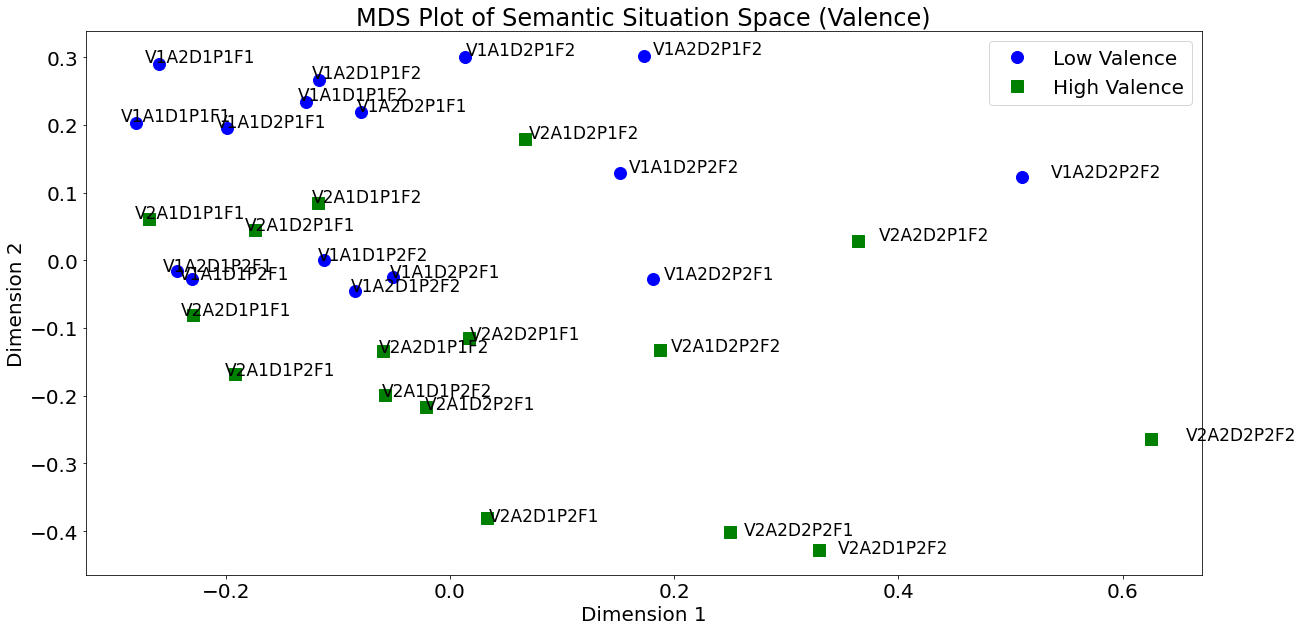

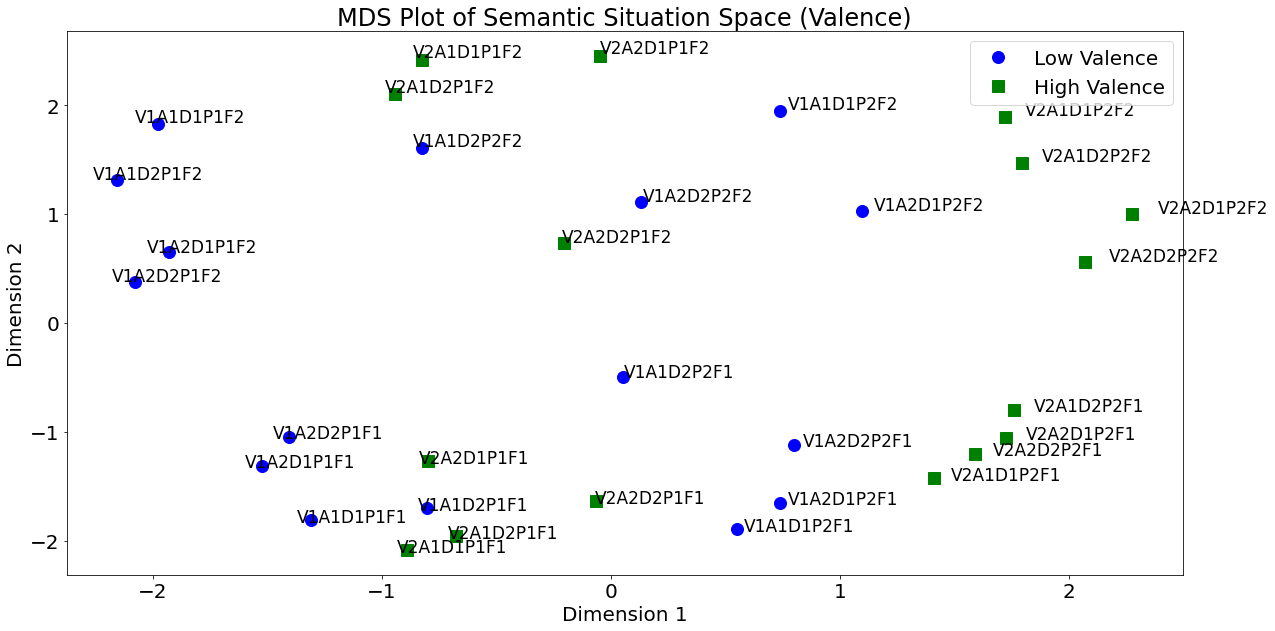

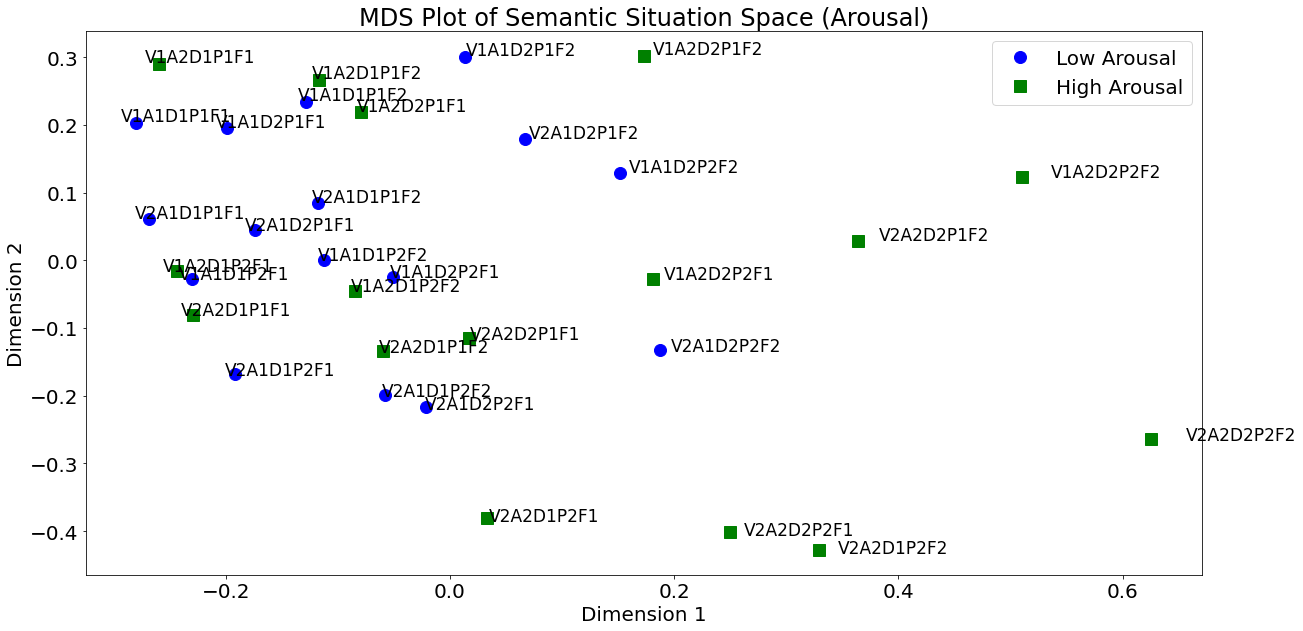

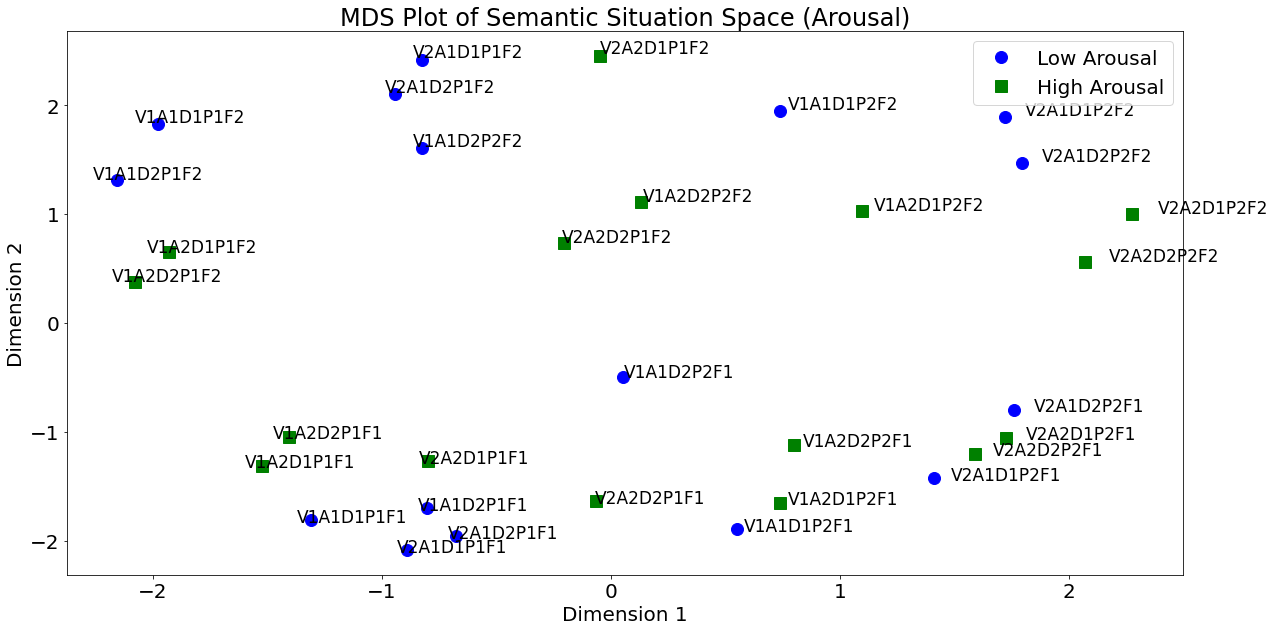

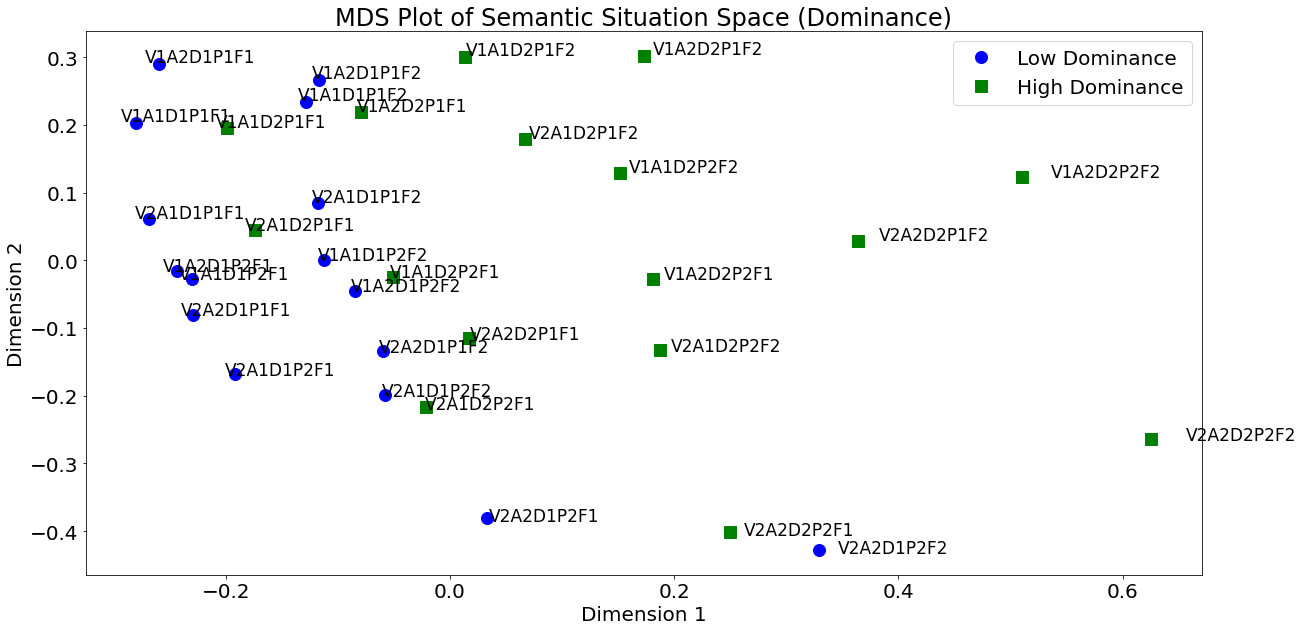

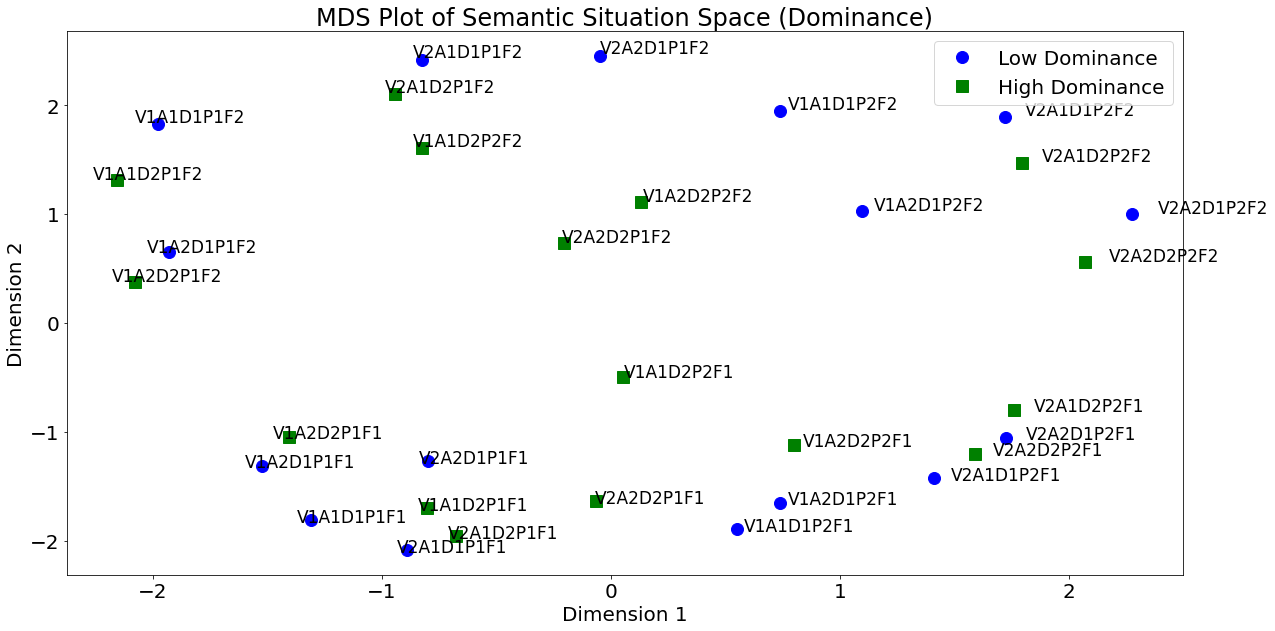

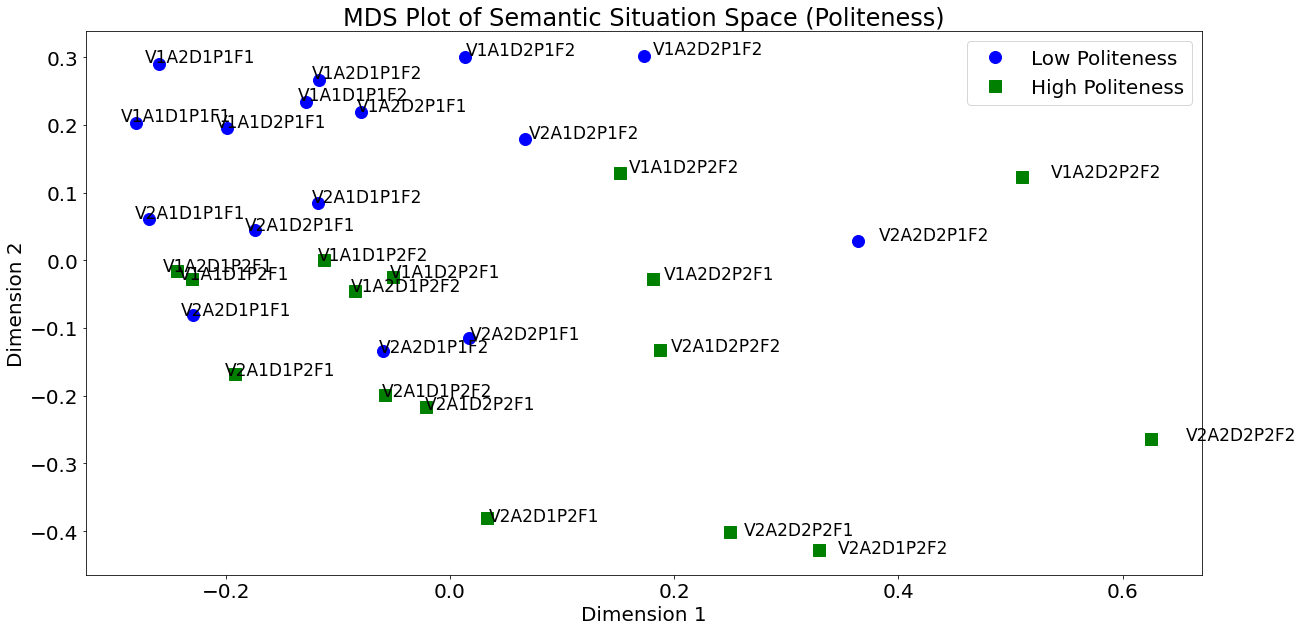

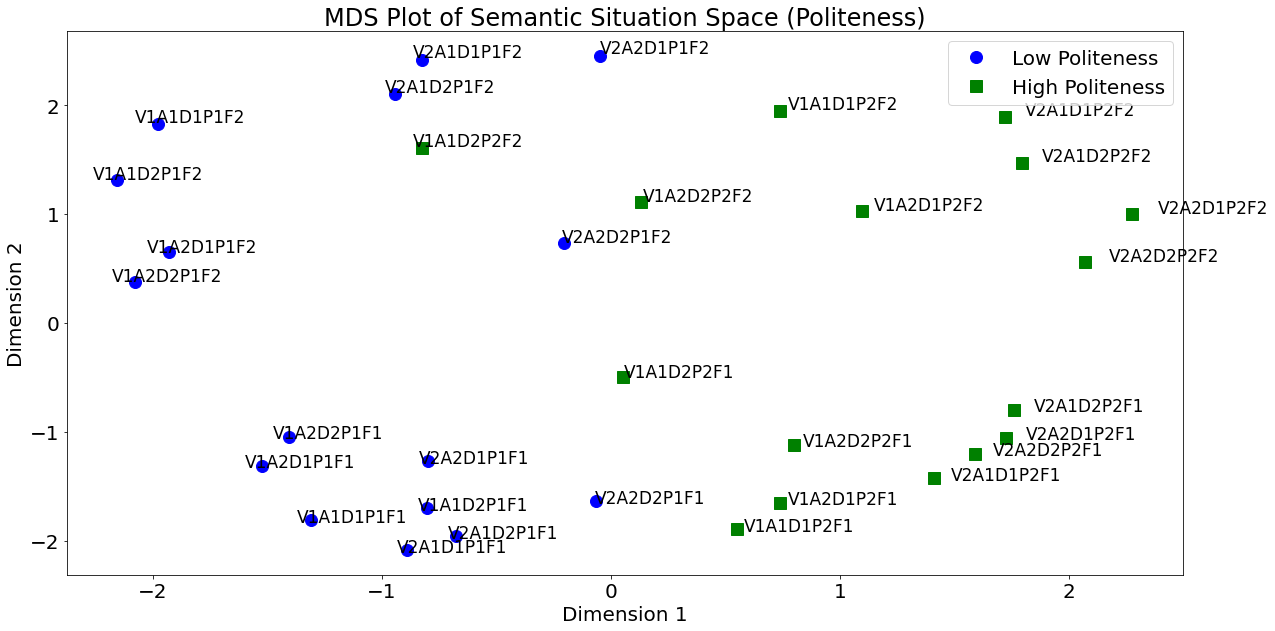

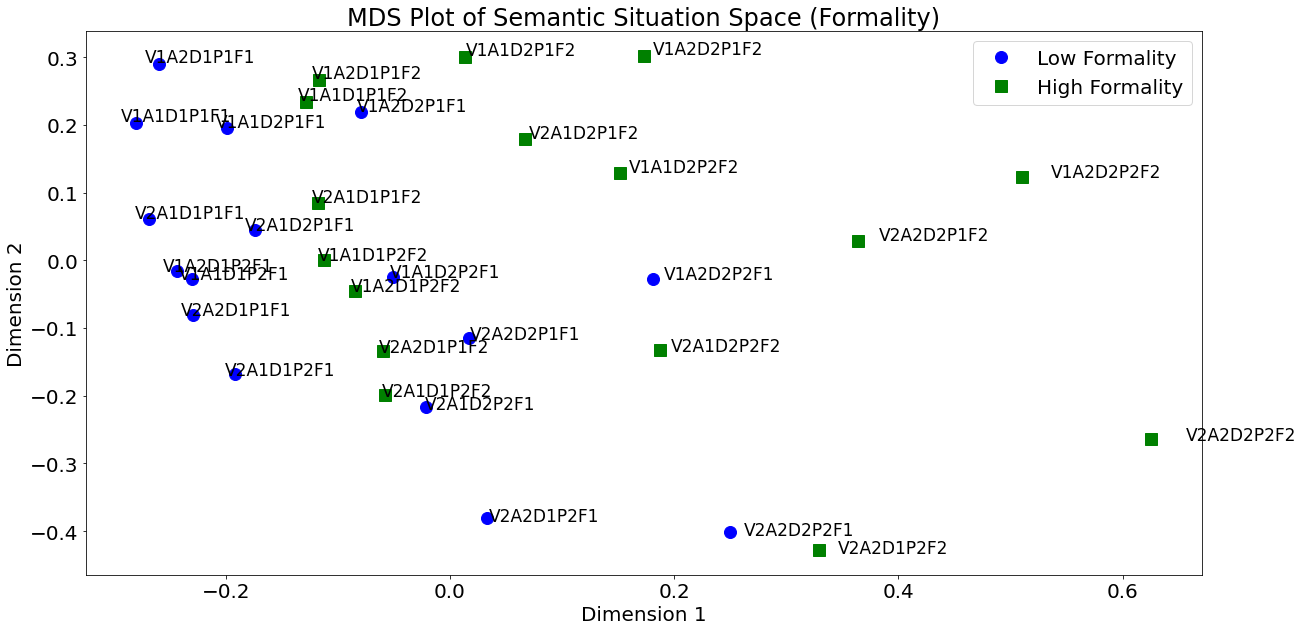

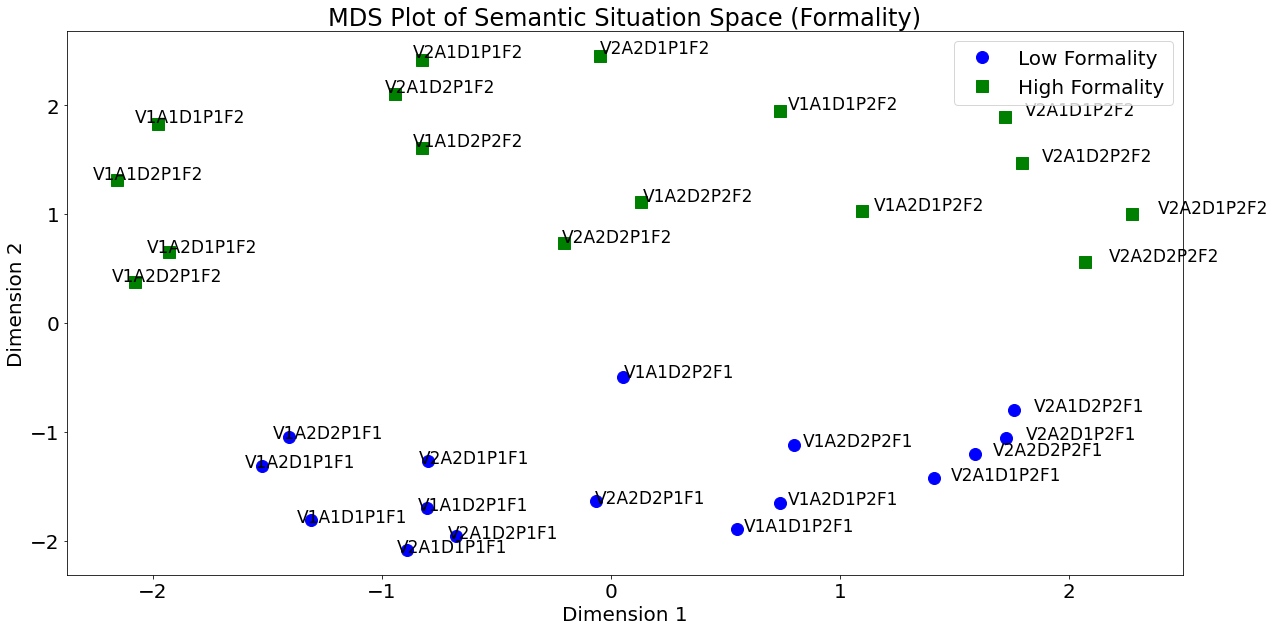

In [96]:
for feature in FEATURE_COLUMNS:
    mds_visualization_2(original_dist_matrix, cooc_matrix.index, feature, lambda x, y, z: x[feature_to_index[z]] == y)
    mds_visualization_2(derived_dist_matrix, cooc_matrix.index, feature, lambda x, y, z: x[feature_to_index[z]] == y)


In [245]:
new_Q = our_q.T[:, :3]
com_to_stance_usage = {}
for i in range(len(comms)):
    sub = new_Q[i*len(markers):(i+1)*len(markers), :]
    # sub.columns = [col[col.index("_") + 1:] for col in sub.columns]
    com_to_stance_usage[comms[i]] = sub

In [246]:
new_Q.shape

#3D visualization
#need probability is fine
# cut down number of questions
# either validation is good


(4540, 3)

In [247]:
com_to_stance_usage[com_1][0]

array([-0.02611922,  0.01935233,  0.02468426])

In [49]:
pairs = []
need_sims = []
stance_sims = []
for com_1 in comms:
    for com_2 in comms:
        if com_1 != com_2:
            if sorted((com_1, com_2)) in pairs:
                continue
            pairs.append(sorted((com_1, com_2)))
            need_sims.append(cosine_similarity(com_to_need[com_1].reshape(1, -1), com_to_need[com_2].reshape(1, -1))[0][0])
            stance_sims.append(np.mean(cosine_similarity(com_to_stance_usage[com_1], com_to_stance_usage[com_2]).diagonal()))

NameError: name 'com_to_stance_usage' is not defined

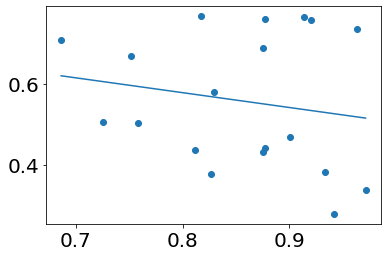

In [288]:
plt.scatter(need_sims, stance_sims)
plt.plot(np.unique(need_sims), np.poly1d(np.polyfit(need_sims, stance_sims, 1))(np.unique(need_sims)))

In [289]:
spearmanr(need_sims, stance_sims)

SpearmanrResult(correlation=-0.19298245614035087, pvalue=0.42861312244412497)

In [290]:
np.argmin(need_sims)

11

In [291]:
vals = np.argsort(need_sims)

In [292]:
np.array(pairs)[vals][-20:]

array([['fantasybaseball', 'whowouldwin'],
       ['fantasybaseball', 'protectandserve'],
       ['fantasybaseball', 'polandball'],
       ['fantasybaseball', 'guns'],
       ['fantasybaseball', 'videos'],
       ['fantasybaseball', 'mildlyinteresting'],
       ['fantasybaseball', 'offmychest'],
       ['fantasybaseball', 'techsupport'],
       ['battlestations', 'fantasybaseball'],
       ['fantasybaseball', 'melbourne'],
       ['fantasy', 'fantasybaseball'],
       ['cardinals', 'fantasybaseball'],
       ['fantasybaseball', 'iama'],
       ['fantasybaseball', 'xboxone'],
       ['fantasybaseball', 'heroesofthestorm'],
       ['fantasybaseball', 'seahawks'],
       ['baseball', 'fantasybaseball'],
       ['diablo3', 'fantasybaseball'],
       ['fantasybaseball', 'fantasyfootball']], dtype='<U17')